#  Conda + SLEAP + Rclone + Installation on AppStream (Linux Platform)

This report contains instructions to install rclone, a service to mount S3 buckets on the local file system, as well as conda, a package manager to install softwares such as SLEAP. Users will be able to lancuh SLEAP and analyze videos from S3 buckets directly. This report is for Amazon Linux 2 Images only.

- [Linux Build Image Instruction](#Linux-Build-Image-Instruction)
    - [Launch Image Builder Step](#Launch-Image-Builder-Step)
    - [Admin User Install Apps Step](#Admin-User-Install-Apps-Step)
    - [Configure Default Settings Step: Without Template User](#Configure-Default-Settings-Step:-Without-Template-User)
    - [Configure Default Settings Step: With Template User](#Configure-Default-Settings-Step:-With-Template-User)
    - [Test Settings Step](#Test-Settings-Step)
    - [Create Image Step](#Create-Image-Step)


## Linux Build Image Instruction

See [Image Builder Guide](./AppStream-Image-Builder-Guide.md) for an overview and explanation of each step.

### Launch Image Builder Step

First, choose base image with `Platform=Amazon Linux 2` and select the latest image. Make sure to choose `Instance Family=Graphics G4` if you want NVIDIA GPU support for SLEAP.

**Reminder**: Your image builder instance and/or fleet instances need to have an IAM role with S3 access attached, so that AppStream would create the `appstream-machine-role` profile for rclone to access the S3 buckets. 

### Admin User Install Apps Step

#### Install Conda

The miniconda package is installed under `/opt/miniconda3` so that environments will be available to all users. 

    # install miniconda:
    wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    sudo bash Miniconda3-latest-Linux-x86_64.sh -p /opt/miniconda3 -b 
    sudo sh -c "echo $'export PATH="/opt/miniconda3/bin:$PATH"\nexport CONDA_ENVS_PATH="/opt/miniconda3/envs"' >> /etc/profile.d/conda.sh"
    source /etc/profile.d/conda.sh # or open a new terminal window

#### Install SLEAP via Conda

It is important that when you install conda packages, you use `sudo /opt/miniconda3/bin/conda` instead of the usual `conda` command. The former will create the environment packages under the `/opt/miniconda3/envs` folder which is available to all users, but the later will by defualt create them under the Image Builder Admin home directory, which is only visible to the Imgae Builder Admin.
    
    # install sleap environment
    sudo /opt/miniconda3/bin/conda create -n sleap -c sleap -c nvidia -c conda-forge sleap=1.3.0 -y
    
#### Install Rclone

To specify a profile name while using rclone, run rclone commands with the flag `--s3-profile appstream_machine_role`, or specify in the config file (as shown below), or set the environment variable `AWS_PROFILE` in the Image Assistant app. 

    # Installing dependencies
    sudo -v ; curl https://rclone.org/install.sh | sudo bash
    sudo amazon-linux-extras install epel -y && sudo yum install fuse3 -y

    # run rclone to create empty ~/.config/rclone/ 
    rclone 
    
    # Create ~/.config/rclone/rclone.conf with contents:
    [s3]
    type = s3
    provider = AWS
    env_auth = true
    region = us-west-2
    location_constraint = us-west-2
    profile = appstream_machine_role
    
### Configure Default Settings Step: Without Template User

You may create configuration files and copy to `/etc/skel` directly, or you may create a Template User and copy all its files to `/etc/skel` as demonstrated in [Configure Default Settings: With Template User](#Configure-Default-Settings:-With-Template-User-(You-may-skip-this)).

#### Conda + SLEAP config

Run the following to set up conda initiation and default sleap environment for all streaming users, so they can use the SLEAP software immediately. 

    # configure conda:
    conda init
    echo "conda activate sleap" >> .bashrc
    sudo cp .bashrc /etc/skel/
    
    # configure sleap:
    source .bashrc
    sleap-label
    sudo cp .sleap .keras .nv .config/matplotlib /etc/skel -r --parents
    
#### Rclone config

Run the following to mount certain S3 buckets on startup for all streaming users. 

    
    # In .bashrc: mount bucket with rclone as daemon process (i.e. in background)
    export MOUNT_PATH=${HOME}/s3-mount
    rclone mount s3:aind-appstream-data-dev-temporary $MOUNT_PATH --daemon
    
    # Move config file to image builder skeleton
    sudo cp .config/rclone/rclone.conf /etc/skel/ --parents
    sudo cp .bashrc /etc/skel/
    sudo mkdir /etc/skel/s3-mount
    
    # Instructions to unmount bucket
    # usermount -u $MOUNT_PATH

### Configure Default Settings: With Template User

Create a Template User and set up default configurations, then copy them to `/etc/skel`.

Initiating conda would effectivly modify the `.bashrc` file (so theoretically you could also directly modify the `/etc/skel/.bashrc` file without creating a Template User, as shown in [Configure Default Settings: With Template User](#Configure-Default-Settings-Step:-Without-Template-User). 

    # create Template User
    sudo useradd -m TemplateUser
    echo -e '<password>\n<password>\n' | sudo passwd TemplateUser # fill in <password> with your choice of password
    su TemplateUser
    cd $HOME
    
    # initialize conda and set sleap as default env
    conda init
    echo "conda activate sleap" >> .bashrc
    
You may also open the SLEAP GUI while in TemplateUser so that the configurations file (e.g. `sleap/1.3.0/preferences.yaml`) would be created for the first time, and can get captured during optimization, so streaming users can open the GUI much faster. 

    # create sleap config files
    source .bashrc
    sleap-label
    
    exit
    sudo cp -r -f /home/TemplateUser/. /etc/skel
    sudo killall -u TemplateUser
    sudo userdel -r TemplateUser
    
You may also set environment variables as a Template User. 
    
    export AWS_PROFILE="appstream_machine_role" 
    
However, you can also set environment variables using the Image Assistant console, as shown in the figure below. 

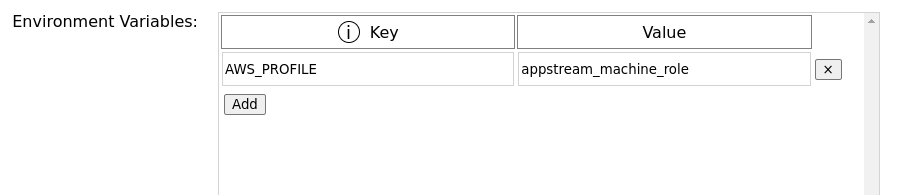


### Test Settings Step

You may create another Test User to check that the configuration files are created correctly in the user's home directory. You should notice that the base conda environment is automatically activated, indicating that conda has already been initialized. If you launch the SLEAP GUI once again, it should open up with a much shorter wait time. 

    # create Test User
    sudo useradd -m TestUser
    echo -e 'temppassword\ntemppassword\n' | sudo passwd TestUser
    su TestUser
    
    # Test sleap GUI launch time
    conda activate sleap
    time sleap-label

### Create Image Step

Use the Image Assistance and add Terminal as app. No launch parameters are added since the default conda environment was already set by the .bashrc file. 

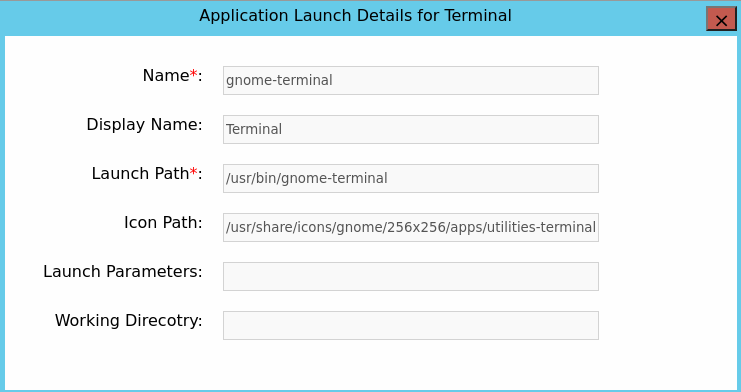